In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve 
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score, confusion_matrix

from collections import Counter

from helper import clean_churn_df, model_baseline, model_baseline_no_cv, score_model_no_cv, score_model
from helper import split_with_dupe_rows_in_train, rf_no_cv_iterx

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from sqlalchemy import create_engine

#plt.style.use('ggplot')
%matplotlib inline


#%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2


In [2]:
from sqlid import sql_id
engine = create_engine(sql_id()) #stored my unique SQL identifier in a variable, set 

churn_df = pd.read_sql_query('select * from hr',con=engine)  
churn_df.drop('index', axis=1,inplace=True)

## Check out dupes

In [4]:
churn_df.duplicated().sum()/churn_df.shape[0]

0.2005467031135409

20% of my data is dupes. Let's see how it varies against other data.

In [5]:
dupes_df = churn_df[churn_df.duplicated()==True]

In [7]:
dupes_df.describe() #lower satisfaction, more time spent at company, more got promoted.

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000
mean,0.545765,0.713787,3.803856,203.349734,4.029920,0.106051,0.525266,0.038564
std,0.266406,0.182012,1.477272,54.467101,1.795619,0.307953,0.499444,0.192585
min,0.090000,0.360000,2.000000,97.000000,2.000000,0.000000,0.000000,0.000000
25%,0.380000,0.540000,2.000000,151.000000,3.000000,0.000000,0.000000,0.000000
50%,0.530000,0.725000,4.000000,204.000000,3.000000,0.000000,1.000000,0.000000
75%,0.780000,0.880000,5.000000,253.000000,5.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [8]:
churn_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


## Exploratory EDA

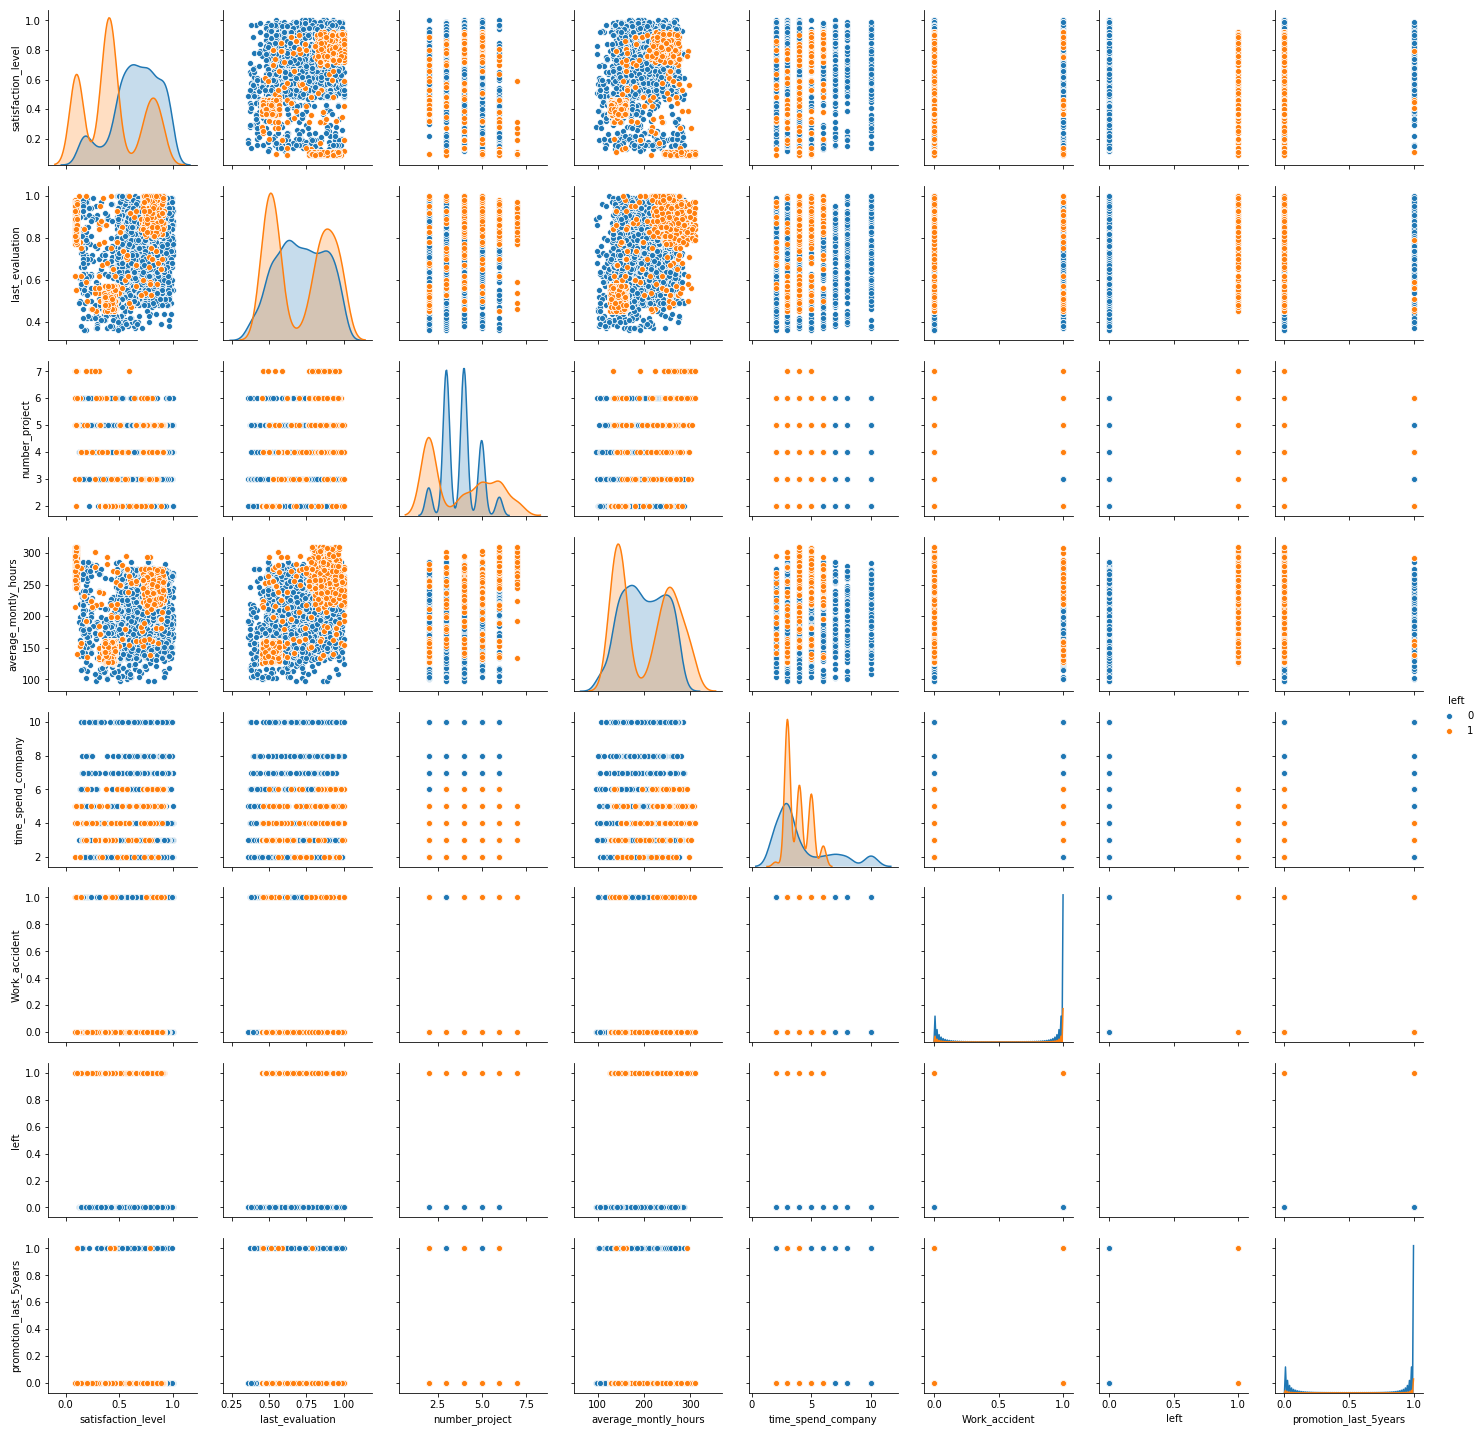

In [6]:
sns.pairplot(dupes_df, hue='left');

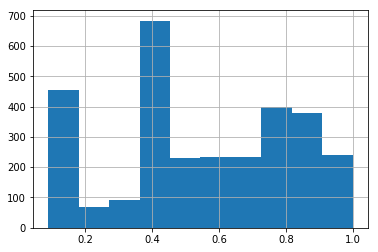

In [9]:
dupes_df['satisfaction_level'].hist()

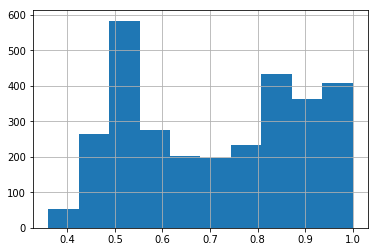

In [10]:
dupes_df['last_evaluation'].hist()

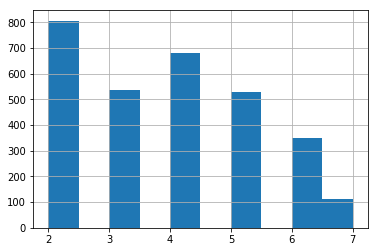

In [11]:
dupes_df['number_project'].hist()

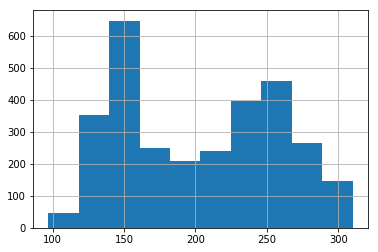

In [12]:
dupes_df['average_montly_hours'].hist()

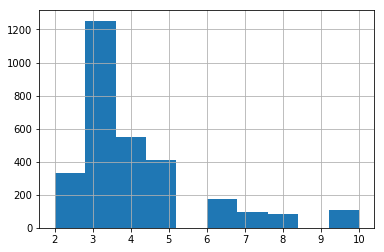

In [13]:
dupes_df['time_spend_company'].hist() #how many years have they been there? Could create a feature of left by years

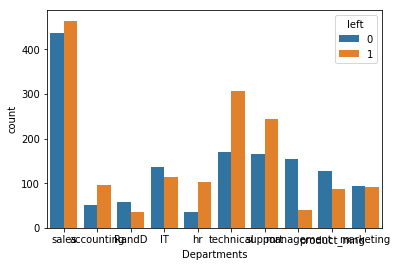

In [16]:
dupes_df.columns = dupes_df.columns.str.strip()
a = sns.countplot('Departments',data=dupes_df, hue='left') #sales had most attrition
#g.set_xticklabels(rotation=30)

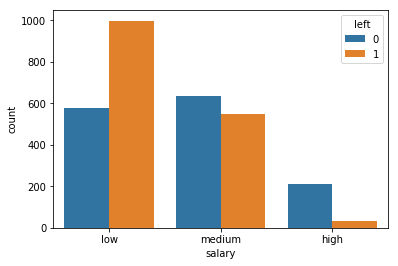

In [19]:
sns.countplot('salary',data=dupes_df, hue='left') #higher salary were more likely to leave

## Conclusion

Dupes are 20% of the data but more or less similar. They have a 5% lower mean satisfaction score and on average have spent .5 years longer at the company.